In [23]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

In [2]:
DATA_DIRECTORY = "/kaggle/input/abstract-art-gallery/Abstract_gallery"
normalization_stats = (.5, .5, .5), (.5, .5, .5)

In [3]:
transform_pipeline = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
])

dataset = torchvision.datasets.ImageFolder(root=DATA_DIRECTORY, transform=transform_pipeline)

In [4]:
def denormalize(image_tensor):
    return image_tensor * normalization_stats[1][0] + normalization_stats[0][0]

In [5]:
batch_size_value = 128
data_loader = DataLoader(dataset, batch_size_value, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def display_images(data_loader):
    for imgs, _ in data_loader:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denormalize(imgs.detach()[:32]), nrow=8).permute(1, 2, 0))
        break

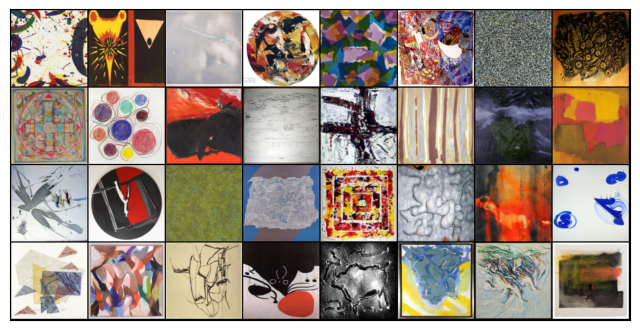

In [7]:
display_images(data_loader)

In [8]:
def get_computation_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [9]:
def move_to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoaderWrapper:
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    def __iter__(self):
        for batch in self.data_loader:
            yield move_to_device(batch, self.device)

    def __len__(self):
        return len(self.data_loader)

In [11]:
device = get_computation_device()
data_loader = DeviceDataLoaderWrapper(data_loader, device)

In [12]:
discriminator_network = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator_network = move_to_device(discriminator_network, device)

In [14]:
latent_dimension = 128
generator_network = nn.Sequential(
    nn.ConvTranspose2d(latent_dimension, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

In [15]:
generator_network = move_to_device(generator_network, device)

In [16]:
def train_discriminator(real_images, optimizer_d):
    optimizer_d.zero_grad()

    real_predictions = discriminator_network(real_images)
    real_labels = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_predictions, real_labels)
    real_score = torch.mean(real_predictions).item()

    latent_vectors = torch.randn(real_images.size(0), latent_dimension, 1, 1, device=device)
    generated_images = generator_network(latent_vectors)

    fake_predictions = discriminator_network(generated_images)
    fake_labels = torch.zeros(generated_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_predictions, fake_labels)
    fake_score = torch.mean(fake_predictions).item()

    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer_d.step()

    return total_loss.item(), real_score, fake_score

In [17]:
def train_generator(optimizer_g):
    optimizer_g.zero_grad()

    latent_vectors = torch.randn(batch_size_value, latent_dimension, 1, 1, device=device)
    generated_images = generator_network(latent_vectors)

    predictions = discriminator_network(generated_images)
    labels = torch.ones(generated_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(predictions, labels)

    loss.backward()
    optimizer_g.step()

    return loss.item()

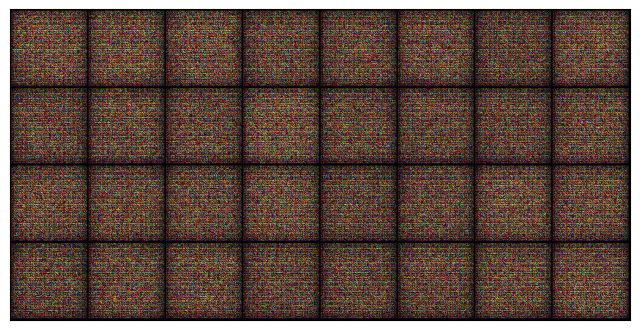

In [18]:
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

def save_generated_images(epoch_index, fixed_latent_vectors, display=False):
    generated_images = generator_network(fixed_latent_vectors)
    file_name = f"generated-images-{epoch_index:04d}.png"
    save_image(denormalize(generated_images), os.path.join(output_dir, file_name), nrow=8)
    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(generated_images.cpu().detach()[:32], nrow=8).permute(1, 2, 0))

fixed_latent_vectors = torch.randn(128, latent_dimension, 1, 1, device=device)
save_generated_images(0, fixed_latent_vectors, display=True)

In [19]:
def train_model(num_epochs, learning_rate_d, learning_rate_g, start_epoch=1):
    torch.cuda.empty_cache()

    discriminator_losses = []
    generator_losses = []
    real_scores_history = []
    fake_scores_history = []
    img_list = []

    optimizer_d = torch.optim.Adam(discriminator_network.parameters(), lr=learning_rate_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator_network.parameters(), lr=learning_rate_g, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for real_images, _ in tqdm(data_loader):
            loss_d, real_score, fake_score = train_discriminator(real_images, optimizer_d)
            loss_g = train_generator(optimizer_g)

        discriminator_losses.append(loss_d)
        generator_losses.append(loss_g)
        real_scores_history.append(real_score)
        fake_scores_history.append(fake_score)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}, Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}")

        save_generated_images(epoch + start_epoch, fixed_latent_vectors, display=False)
        img_list.append(denormalize(generator_network(fixed_latent_vectors)).cpu().detach().numpy())

    return discriminator_losses, generator_losses, real_scores_history, fake_scores_history, img_list

In [20]:
num_epochs = 200
learning_rate_discriminator = 1e-4
learning_rate_generator = 1e-3

discriminator_losses, generator_losses, real_scores_history, fake_scores_history, img_list = train_model(num_epochs, learning_rate_discriminator, learning_rate_generator, start_epoch=1)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1/200], Loss D: 1.4733, Loss G: 3.7071, Real Score: 0.5374, Fake Score: 0.5242


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/200], Loss D: 1.1342, Loss G: 2.6168, Real Score: 0.5241, Fake Score: 0.3394


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/200], Loss D: 1.1165, Loss G: 1.7160, Real Score: 0.5202, Fake Score: 0.3390


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/200], Loss D: 1.2025, Loss G: 2.0813, Real Score: 0.5886, Fake Score: 0.4597


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/200], Loss D: 1.2186, Loss G: 1.9756, Real Score: 0.6962, Fake Score: 0.5351


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/200], Loss D: 1.0377, Loss G: 1.7689, Real Score: 0.6621, Fake Score: 0.4353


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/200], Loss D: 0.7299, Loss G: 1.1882, Real Score: 0.6102, Fake Score: 0.1869


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/200], Loss D: 1.0709, Loss G: 2.2348, Real Score: 0.5668, Fake Score: 0.3512


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/200], Loss D: 1.2437, Loss G: 1.0695, Real Score: 0.5087, Fake Score: 0.3879


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/200], Loss D: 1.0907, Loss G: 1.6705, Real Score: 0.6145, Fake Score: 0.4279


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/200], Loss D: 0.8970, Loss G: 2.1090, Real Score: 0.6428, Fake Score: 0.3382


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/200], Loss D: 0.7756, Loss G: 2.8753, Real Score: 0.6111, Fake Score: 0.1984


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/200], Loss D: 1.0453, Loss G: 1.3552, Real Score: 0.5935, Fake Score: 0.3805


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/200], Loss D: 1.0899, Loss G: 2.6276, Real Score: 0.6598, Fake Score: 0.4531


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/200], Loss D: 1.1875, Loss G: 2.6344, Real Score: 0.6354, Fake Score: 0.4982


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/200], Loss D: 0.8738, Loss G: 1.4588, Real Score: 0.5871, Fake Score: 0.2564


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/200], Loss D: 1.1673, Loss G: 1.6830, Real Score: 0.6389, Fake Score: 0.4835


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/200], Loss D: 1.3125, Loss G: 1.7208, Real Score: 0.6251, Fake Score: 0.5280


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/200], Loss D: 1.3490, Loss G: 1.4276, Real Score: 0.3537, Fake Score: 0.2186


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/200], Loss D: 0.7536, Loss G: 1.6675, Real Score: 0.7738, Fake Score: 0.3701


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/200], Loss D: 0.9338, Loss G: 1.6617, Real Score: 0.6263, Fake Score: 0.3487


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/200], Loss D: 1.1048, Loss G: 1.3383, Real Score: 0.4232, Fake Score: 0.1360


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/200], Loss D: 1.6083, Loss G: 3.7950, Real Score: 0.7654, Fake Score: 0.6980


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/200], Loss D: 0.8569, Loss G: 2.3703, Real Score: 0.4794, Fake Score: 0.0796


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/200], Loss D: 1.3144, Loss G: 2.0631, Real Score: 0.6699, Fake Score: 0.5695


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [26/200], Loss D: 1.0682, Loss G: 1.6044, Real Score: 0.5283, Fake Score: 0.3100


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [27/200], Loss D: 0.8117, Loss G: 2.6887, Real Score: 0.5088, Fake Score: 0.0410


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [28/200], Loss D: 1.8658, Loss G: 4.8132, Real Score: 0.7948, Fake Score: 0.7495


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [29/200], Loss D: 0.9127, Loss G: 2.6480, Real Score: 0.6643, Fake Score: 0.3644


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [30/200], Loss D: 0.9237, Loss G: 2.1374, Real Score: 0.5909, Fake Score: 0.2713


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [31/200], Loss D: 1.3898, Loss G: 2.9342, Real Score: 0.8072, Fake Score: 0.6045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [32/200], Loss D: 1.3171, Loss G: 3.2718, Real Score: 0.7784, Fake Score: 0.6222


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [33/200], Loss D: 0.6588, Loss G: 2.0024, Real Score: 0.6791, Fake Score: 0.2137


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [34/200], Loss D: 0.6804, Loss G: 2.4059, Real Score: 0.6642, Fake Score: 0.2036


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [35/200], Loss D: 0.8904, Loss G: 3.9566, Real Score: 0.7803, Fake Score: 0.4534


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [36/200], Loss D: 0.6438, Loss G: 2.1083, Real Score: 0.8205, Fake Score: 0.3269


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [37/200], Loss D: 1.4802, Loss G: 1.2965, Real Score: 0.3039, Fake Score: 0.1225


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [38/200], Loss D: 0.8139, Loss G: 5.0719, Real Score: 0.9239, Fake Score: 0.4929


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [39/200], Loss D: 1.5280, Loss G: 1.6637, Real Score: 0.4590, Fake Score: 0.4540


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [40/200], Loss D: 1.0885, Loss G: 2.7586, Real Score: 0.7732, Fake Score: 0.5175


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [41/200], Loss D: 0.8445, Loss G: 2.9900, Real Score: 0.7495, Fake Score: 0.3975


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [42/200], Loss D: 0.5652, Loss G: 3.0846, Real Score: 0.8397, Fake Score: 0.3033


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [43/200], Loss D: 0.9451, Loss G: 3.2822, Real Score: 0.7988, Fake Score: 0.4753


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [44/200], Loss D: 0.7888, Loss G: 2.5538, Real Score: 0.6218, Fake Score: 0.2075


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [45/200], Loss D: 0.7087, Loss G: 3.1855, Real Score: 0.7221, Fake Score: 0.2703


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [46/200], Loss D: 1.2175, Loss G: 3.8657, Real Score: 0.8109, Fake Score: 0.5796


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [47/200], Loss D: 0.9461, Loss G: 3.0351, Real Score: 0.8596, Fake Score: 0.5136


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [48/200], Loss D: 1.0015, Loss G: 1.3855, Real Score: 0.5344, Fake Score: 0.2411


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [49/200], Loss D: 2.9944, Loss G: 1.9026, Real Score: 0.0715, Fake Score: 0.0094


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [50/200], Loss D: 1.2099, Loss G: 4.9684, Real Score: 0.8090, Fake Score: 0.5715


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [51/200], Loss D: 1.4163, Loss G: 5.8945, Real Score: 0.8813, Fake Score: 0.6852


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [52/200], Loss D: 0.8725, Loss G: 2.5725, Real Score: 0.6594, Fake Score: 0.3116


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [53/200], Loss D: 0.7280, Loss G: 3.4751, Real Score: 0.8633, Fake Score: 0.4188


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [54/200], Loss D: 1.2758, Loss G: 3.0861, Real Score: 0.8863, Fake Score: 0.6537


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [55/200], Loss D: 0.6219, Loss G: 2.9024, Real Score: 0.8111, Fake Score: 0.3159


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [56/200], Loss D: 1.3539, Loss G: 1.1028, Real Score: 0.3928, Fake Score: 0.1447


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [57/200], Loss D: 0.9710, Loss G: 3.8008, Real Score: 0.7758, Fake Score: 0.4787


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [58/200], Loss D: 0.8950, Loss G: 2.5169, Real Score: 0.6290, Fake Score: 0.2701


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [59/200], Loss D: 1.1706, Loss G: 2.7969, Real Score: 0.4165, Fake Score: 0.1230


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [60/200], Loss D: 1.0818, Loss G: 3.0288, Real Score: 0.7499, Fake Score: 0.5033


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [61/200], Loss D: 1.0732, Loss G: 2.7106, Real Score: 0.6894, Fake Score: 0.4609


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [62/200], Loss D: 1.0577, Loss G: 1.6668, Real Score: 0.4549, Fake Score: 0.1572


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [63/200], Loss D: 0.8786, Loss G: 5.1083, Real Score: 0.8293, Fake Score: 0.4738


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [64/200], Loss D: 1.4333, Loss G: 5.7553, Real Score: 0.8735, Fake Score: 0.6872


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [65/200], Loss D: 0.5685, Loss G: 3.4672, Real Score: 0.7306, Fake Score: 0.1907


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [66/200], Loss D: 1.6364, Loss G: 2.1108, Real Score: 0.4789, Fake Score: 0.5066


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [67/200], Loss D: 0.8689, Loss G: 1.6550, Real Score: 0.5896, Fake Score: 0.2244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [68/200], Loss D: 1.0686, Loss G: 2.4746, Real Score: 0.8022, Fake Score: 0.5214


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [69/200], Loss D: 1.0795, Loss G: 3.5130, Real Score: 0.6570, Fake Score: 0.4159


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [70/200], Loss D: 0.8954, Loss G: 2.4834, Real Score: 0.6516, Fake Score: 0.3144


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [71/200], Loss D: 0.8345, Loss G: 3.1652, Real Score: 0.7802, Fake Score: 0.4140


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [72/200], Loss D: 0.9242, Loss G: 2.8150, Real Score: 0.6702, Fake Score: 0.3674


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [73/200], Loss D: 0.9080, Loss G: 3.1699, Real Score: 0.8504, Fake Score: 0.4882


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [74/200], Loss D: 0.5957, Loss G: 2.6195, Real Score: 0.7448, Fake Score: 0.2308


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [75/200], Loss D: 0.9132, Loss G: 2.6856, Real Score: 0.6927, Fake Score: 0.3882


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [76/200], Loss D: 0.6385, Loss G: 2.0592, Real Score: 0.7806, Fake Score: 0.2931


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [77/200], Loss D: 0.8946, Loss G: 2.0750, Real Score: 0.7484, Fake Score: 0.4086


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [78/200], Loss D: 0.8396, Loss G: 1.8320, Real Score: 0.6405, Fake Score: 0.2800


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [79/200], Loss D: 0.7290, Loss G: 3.0613, Real Score: 0.7450, Fake Score: 0.3142


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [80/200], Loss D: 1.2281, Loss G: 4.5725, Real Score: 0.8870, Fake Score: 0.6317


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [81/200], Loss D: 1.2399, Loss G: 3.6631, Real Score: 0.6539, Fake Score: 0.4958


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [82/200], Loss D: 1.3478, Loss G: 3.4099, Real Score: 0.7470, Fake Score: 0.6142


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [83/200], Loss D: 0.8597, Loss G: 1.7093, Real Score: 0.5551, Fake Score: 0.1868


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [84/200], Loss D: 0.7984, Loss G: 4.1288, Real Score: 0.8987, Fake Score: 0.4752


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [85/200], Loss D: 1.7175, Loss G: 1.3395, Real Score: 0.2350, Fake Score: 0.0293


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [86/200], Loss D: 0.8122, Loss G: 2.9724, Real Score: 0.7399, Fake Score: 0.3559


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [87/200], Loss D: 1.0174, Loss G: 1.0057, Real Score: 0.4525, Fake Score: 0.1021


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [88/200], Loss D: 1.2123, Loss G: 2.8718, Real Score: 0.5689, Fake Score: 0.4099


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [89/200], Loss D: 0.9620, Loss G: 3.7308, Real Score: 0.8488, Fake Score: 0.5175


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [90/200], Loss D: 0.8540, Loss G: 2.4276, Real Score: 0.6905, Fake Score: 0.3417


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [91/200], Loss D: 0.9211, Loss G: 1.7844, Real Score: 0.5533, Fake Score: 0.2130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [92/200], Loss D: 0.9613, Loss G: 1.3680, Real Score: 0.4797, Fake Score: 0.1178


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [93/200], Loss D: 1.4045, Loss G: 0.7520, Real Score: 0.3586, Fake Score: 0.1823


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [94/200], Loss D: 1.7416, Loss G: 1.0868, Real Score: 0.2511, Fake Score: 0.1710


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [95/200], Loss D: 0.9161, Loss G: 1.7521, Real Score: 0.5753, Fake Score: 0.2543


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [96/200], Loss D: 0.8103, Loss G: 2.0432, Real Score: 0.6618, Fake Score: 0.2875


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [97/200], Loss D: 1.2041, Loss G: 0.9851, Real Score: 0.4170, Fake Score: 0.1808


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [98/200], Loss D: 0.7856, Loss G: 2.6210, Real Score: 0.6648, Fake Score: 0.2812


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [99/200], Loss D: 1.0459, Loss G: 3.4554, Real Score: 0.7316, Fake Score: 0.4870


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [100/200], Loss D: 1.2893, Loss G: 1.6505, Real Score: 0.5547, Fake Score: 0.3559


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [101/200], Loss D: 0.6605, Loss G: 3.4546, Real Score: 0.7900, Fake Score: 0.3210


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [102/200], Loss D: 1.0336, Loss G: 2.2569, Real Score: 0.6802, Fake Score: 0.4391


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [103/200], Loss D: 1.0026, Loss G: 2.1027, Real Score: 0.6410, Fake Score: 0.3861


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [104/200], Loss D: 1.0129, Loss G: 2.5164, Real Score: 0.5989, Fake Score: 0.3244


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [105/200], Loss D: 0.9998, Loss G: 1.8031, Real Score: 0.5581, Fake Score: 0.2909


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [106/200], Loss D: 0.8782, Loss G: 2.3876, Real Score: 0.7608, Fake Score: 0.4078


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [107/200], Loss D: 0.9840, Loss G: 3.9306, Real Score: 0.7888, Fake Score: 0.4733


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [108/200], Loss D: 0.9951, Loss G: 2.6547, Real Score: 0.5766, Fake Score: 0.2995


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [109/200], Loss D: 0.8107, Loss G: 1.7820, Real Score: 0.5832, Fake Score: 0.1869


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [110/200], Loss D: 0.7578, Loss G: 1.8695, Real Score: 0.5628, Fake Score: 0.1169


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [111/200], Loss D: 0.8327, Loss G: 3.0374, Real Score: 0.6776, Fake Score: 0.3024


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [112/200], Loss D: 0.9818, Loss G: 3.3419, Real Score: 0.7045, Fake Score: 0.4245


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [113/200], Loss D: 0.9982, Loss G: 1.6769, Real Score: 0.5166, Fake Score: 0.2130


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [114/200], Loss D: 0.8921, Loss G: 2.3542, Real Score: 0.5516, Fake Score: 0.1904


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [115/200], Loss D: 1.8122, Loss G: 3.2111, Real Score: 0.9045, Fake Score: 0.7832


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [116/200], Loss D: 0.9217, Loss G: 2.3920, Real Score: 0.7257, Fake Score: 0.3982


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [117/200], Loss D: 1.1714, Loss G: 3.6977, Real Score: 0.6298, Fake Score: 0.4491


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [118/200], Loss D: 1.0262, Loss G: 2.8353, Real Score: 0.8548, Fake Score: 0.5414


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [119/200], Loss D: 0.7246, Loss G: 2.0814, Real Score: 0.6400, Fake Score: 0.1955


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [120/200], Loss D: 0.8517, Loss G: 2.0411, Real Score: 0.6250, Fake Score: 0.2673


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [121/200], Loss D: 0.8367, Loss G: 2.5091, Real Score: 0.7603, Fake Score: 0.3982


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [122/200], Loss D: 1.3263, Loss G: 1.2350, Real Score: 0.3341, Fake Score: 0.0750


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [123/200], Loss D: 1.0156, Loss G: 3.2306, Real Score: 0.7848, Fake Score: 0.4949


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [124/200], Loss D: 1.1541, Loss G: 4.6492, Real Score: 0.9016, Fake Score: 0.6134


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [125/200], Loss D: 1.2195, Loss G: 3.5338, Real Score: 0.8030, Fake Score: 0.5852


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [126/200], Loss D: 0.9390, Loss G: 4.1980, Real Score: 0.8480, Fake Score: 0.4934


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [127/200], Loss D: 1.1126, Loss G: 3.1438, Real Score: 0.6335, Fake Score: 0.4224


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [128/200], Loss D: 0.9775, Loss G: 1.6975, Real Score: 0.4935, Fake Score: 0.1466


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [129/200], Loss D: 0.8305, Loss G: 1.5183, Real Score: 0.5238, Fake Score: 0.1102


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [130/200], Loss D: 1.0677, Loss G: 2.6859, Real Score: 0.6129, Fake Score: 0.3848


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [131/200], Loss D: 0.9816, Loss G: 1.8456, Real Score: 0.6153, Fake Score: 0.3363


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [132/200], Loss D: 1.0164, Loss G: 2.9470, Real Score: 0.6877, Fake Score: 0.4149


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [133/200], Loss D: 1.0735, Loss G: 3.2362, Real Score: 0.7811, Fake Score: 0.5226


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [134/200], Loss D: 1.1215, Loss G: 1.9635, Real Score: 0.3897, Fake Score: 0.0618


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [135/200], Loss D: 0.7804, Loss G: 3.7209, Real Score: 0.8745, Fake Score: 0.4325


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [136/200], Loss D: 1.5797, Loss G: 4.7863, Real Score: 0.8530, Fake Score: 0.7178


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [137/200], Loss D: 0.9555, Loss G: 1.7762, Real Score: 0.4879, Fake Score: 0.1150


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [138/200], Loss D: 0.8819, Loss G: 3.6469, Real Score: 0.8478, Fake Score: 0.4749


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [139/200], Loss D: 0.9126, Loss G: 4.4393, Real Score: 0.8388, Fake Score: 0.4855


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [140/200], Loss D: 0.8037, Loss G: 3.0794, Real Score: 0.7114, Fake Score: 0.3347


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [141/200], Loss D: 0.7816, Loss G: 3.3533, Real Score: 0.7218, Fake Score: 0.3313


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [142/200], Loss D: 0.7559, Loss G: 3.0396, Real Score: 0.7722, Fake Score: 0.3542


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [143/200], Loss D: 0.6476, Loss G: 1.4843, Real Score: 0.6373, Fake Score: 0.1415


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [144/200], Loss D: 0.9270, Loss G: 1.7347, Real Score: 0.5979, Fake Score: 0.2813


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [145/200], Loss D: 0.6870, Loss G: 3.4757, Real Score: 0.7382, Fake Score: 0.2860


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [146/200], Loss D: 0.8832, Loss G: 4.5759, Real Score: 0.8349, Fake Score: 0.4725


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [147/200], Loss D: 0.9463, Loss G: 3.6505, Real Score: 0.8908, Fake Score: 0.5216


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [148/200], Loss D: 0.9480, Loss G: 1.7727, Real Score: 0.5133, Fake Score: 0.1480


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [149/200], Loss D: 1.3578, Loss G: 1.3474, Real Score: 0.3308, Fake Score: 0.0761


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [150/200], Loss D: 1.0234, Loss G: 1.6019, Real Score: 0.5715, Fake Score: 0.3156


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [151/200], Loss D: 1.1171, Loss G: 2.4055, Real Score: 0.4906, Fake Score: 0.2080


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [152/200], Loss D: 2.0079, Loss G: 4.8837, Real Score: 0.9497, Fake Score: 0.8158


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [153/200], Loss D: 0.6482, Loss G: 2.1911, Real Score: 0.7874, Fake Score: 0.3039


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [154/200], Loss D: 1.0447, Loss G: 3.0354, Real Score: 0.6284, Fake Score: 0.3896


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [155/200], Loss D: 0.7979, Loss G: 3.1184, Real Score: 0.8203, Fake Score: 0.4168


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [156/200], Loss D: 1.0201, Loss G: 1.3859, Real Score: 0.4898, Fake Score: 0.1657


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [157/200], Loss D: 0.8899, Loss G: 1.4379, Real Score: 0.6233, Fake Score: 0.2918


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [158/200], Loss D: 0.5860, Loss G: 2.1141, Real Score: 0.7714, Fake Score: 0.2531


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [159/200], Loss D: 0.5987, Loss G: 3.1715, Real Score: 0.7683, Fake Score: 0.2541


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [160/200], Loss D: 1.0612, Loss G: 1.8008, Real Score: 0.4290, Fake Score: 0.0783


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [161/200], Loss D: 0.5466, Loss G: 2.5977, Real Score: 0.6604, Fake Score: 0.0931


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [162/200], Loss D: 0.8479, Loss G: 3.4340, Real Score: 0.8198, Fake Score: 0.4493


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [163/200], Loss D: 1.0303, Loss G: 3.0299, Real Score: 0.8073, Fake Score: 0.4892


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [164/200], Loss D: 0.7381, Loss G: 3.8063, Real Score: 0.8141, Fake Score: 0.3774


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [165/200], Loss D: 1.0966, Loss G: 1.4701, Real Score: 0.4374, Fake Score: 0.1159


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [166/200], Loss D: 0.9235, Loss G: 3.1516, Real Score: 0.8493, Fake Score: 0.4934


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [167/200], Loss D: 0.8381, Loss G: 2.3884, Real Score: 0.6977, Fake Score: 0.3410


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [168/200], Loss D: 1.1278, Loss G: 1.6920, Real Score: 0.4435, Fake Score: 0.1019


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [169/200], Loss D: 0.7791, Loss G: 3.8604, Real Score: 0.7872, Fake Score: 0.3761


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [170/200], Loss D: 0.6622, Loss G: 3.5276, Real Score: 0.8127, Fake Score: 0.3316


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [171/200], Loss D: 1.3236, Loss G: 0.9824, Real Score: 0.3384, Fake Score: 0.0638


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [172/200], Loss D: 0.7223, Loss G: 1.9296, Real Score: 0.6281, Fake Score: 0.1788


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [173/200], Loss D: 0.6084, Loss G: 2.4092, Real Score: 0.6685, Fake Score: 0.1485


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [174/200], Loss D: 1.0869, Loss G: 1.5321, Real Score: 0.4430, Fake Score: 0.1136


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [175/200], Loss D: 0.9305, Loss G: 3.8763, Real Score: 0.9122, Fake Score: 0.5203


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [176/200], Loss D: 0.7215, Loss G: 3.0320, Real Score: 0.7825, Fake Score: 0.3439


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [177/200], Loss D: 0.8865, Loss G: 3.5881, Real Score: 0.7629, Fake Score: 0.4171


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [178/200], Loss D: 0.9892, Loss G: 4.3102, Real Score: 0.8895, Fake Score: 0.5246


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [179/200], Loss D: 0.4035, Loss G: 3.3371, Real Score: 0.8034, Fake Score: 0.1489


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [180/200], Loss D: 0.7477, Loss G: 3.7463, Real Score: 0.8482, Fake Score: 0.4045


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [181/200], Loss D: 0.7577, Loss G: 2.6589, Real Score: 0.7573, Fake Score: 0.3445


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [182/200], Loss D: 0.6196, Loss G: 2.8258, Real Score: 0.8222, Fake Score: 0.3193


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [183/200], Loss D: 0.4807, Loss G: 3.9025, Real Score: 0.9026, Fake Score: 0.2895


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [184/200], Loss D: 1.2631, Loss G: 0.8541, Real Score: 0.3546, Fake Score: 0.0562


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [185/200], Loss D: 0.4577, Loss G: 2.8134, Real Score: 0.8678, Fake Score: 0.2465


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [186/200], Loss D: 1.0852, Loss G: 5.2406, Real Score: 0.8711, Fake Score: 0.5729


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [187/200], Loss D: 0.9666, Loss G: 5.2250, Real Score: 0.8598, Fake Score: 0.5123


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [188/200], Loss D: 0.4938, Loss G: 2.6728, Real Score: 0.9025, Fake Score: 0.3051


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [189/200], Loss D: 0.6124, Loss G: 1.8237, Real Score: 0.6623, Fake Score: 0.1433


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [190/200], Loss D: 0.5726, Loss G: 2.4621, Real Score: 0.6489, Fake Score: 0.0855


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [191/200], Loss D: 0.7979, Loss G: 3.6101, Real Score: 0.8753, Fake Score: 0.4356


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [192/200], Loss D: 0.6187, Loss G: 1.9372, Real Score: 0.7240, Fake Score: 0.2114


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [193/200], Loss D: 0.8784, Loss G: 4.0184, Real Score: 0.8776, Fake Score: 0.4877


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [194/200], Loss D: 1.6337, Loss G: 2.5824, Real Score: 0.2600, Fake Score: 0.0129


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [195/200], Loss D: 0.3883, Loss G: 2.2225, Real Score: 0.8180, Fake Score: 0.1555


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [196/200], Loss D: 1.1961, Loss G: 5.2278, Real Score: 0.9366, Fake Score: 0.6227


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [197/200], Loss D: 0.6400, Loss G: 4.5253, Real Score: 0.9354, Fake Score: 0.4078


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [198/200], Loss D: 0.7768, Loss G: 5.1168, Real Score: 0.9186, Fake Score: 0.4561


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [199/200], Loss D: 0.4239, Loss G: 4.3582, Real Score: 0.8661, Fake Score: 0.2240


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [200/200], Loss D: 0.9101, Loss G: 5.8068, Real Score: 0.9369, Fake Score: 0.5104


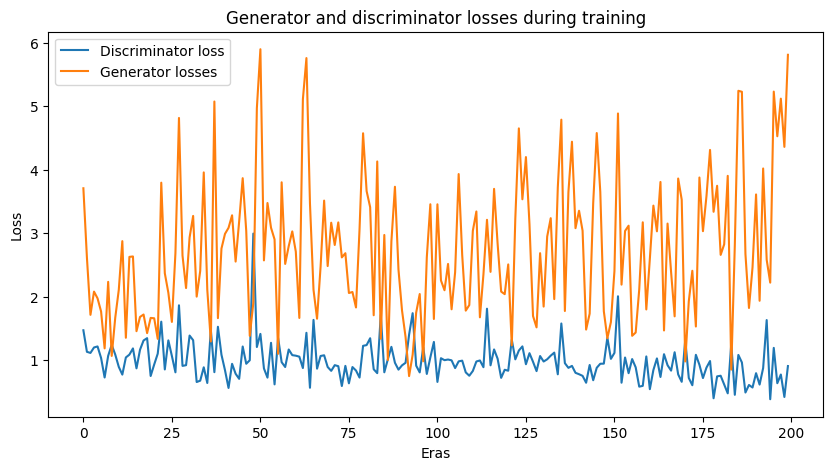

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Generator and discriminator losses during training")
plt.plot(discriminator_losses, label="Discriminator loss")
plt.plot(generator_losses, label="Generator losses")
plt.xlabel("Eras")
plt.ylabel("Loss")
plt.legend()
plt.show()

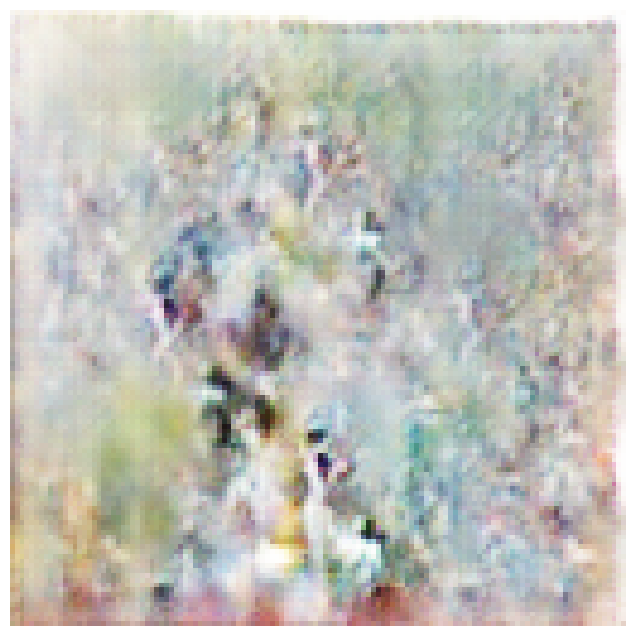

In [30]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(img[0], (1, 2, 0)), animated=True)] for img in img_list[::6]]

ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())